In [698]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

In [699]:
rooth_path = 'data/'
deng_sj = pd.read_csv(rooth_path + 'deng_sj.csv')
deng_iq = pd.read_csv(rooth_path + 'deng_iq.csv')
test_sj = pd.read_csv(rooth_path + 'test_sj.csv')
test_iq = pd.read_csv(rooth_path + 'test_iq.csv')

In [700]:
def convert_celsius(df):
    
    k = 273.15
    
    # convert to celsius
    df['reanalysis_air_temp_k'] -= k
    df['reanalysis_avg_temp_k'] -= k
    df['reanalysis_dew_point_temp_k'] -= k
    df['reanalysis_max_air_temp_k'] -= k
    df['reanalysis_min_air_temp_k'] -= k
    
    # change features names
    col = df.columns
    col = col.str.replace('temp_k', 'temp_c')
    df.columns = col.str.replace('tdtr_k', 'tdtr_c')
    
    return df

In [701]:
deng_sj = convert_celsius(deng_sj)
deng_iq = convert_celsius(deng_iq)
test_sj = convert_celsius(test_sj)
test_iq = convert_celsius(test_iq)

In [702]:
def mean_ndvi(df):
    
    df['ndvi_mean'] = df[df.columns[3:7]].mean(axis = 1)
    
    return df

In [703]:
deng_sj = mean_ndvi(deng_sj)
deng_iq = mean_ndvi(deng_iq)
test_sj = mean_ndvi(test_sj)
test_iq = mean_ndvi(test_iq)

In [704]:
def feature_selection(df, columns):
    
    df.drop(columns = columns, inplace=True)
    
    return df

In [705]:
deng_sj = feature_selection(deng_sj, ['reanalysis_air_temp_c', 'reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_c'])
deng_iq = feature_selection(deng_iq, ['reanalysis_avg_temp_c', 'reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_c'])
test_sj = feature_selection(test_sj, ['reanalysis_air_temp_c', 'reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_c'])
test_iq = feature_selection(test_iq, ['reanalysis_avg_temp_c', 'reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_c'])

In [706]:
def rolling_feat(df, df_test, roll_win_size, city):
    
    # save total cases in a dataframe
    total_cases = df[['city', 'year', 'weekofyear', 'total_cases']]
    
    df.drop(columns=['total_cases'], inplace=True)
    
    total_df = pd.concat([df, df_test], axis=0)
    
    cols = total_df.columns[4:] #Features columns excluding week_start_date, city and weekofyear
    
    for col in cols:
        total_df[col + '_sum']  = total_df[col].rolling(roll_win_size).sum()
        total_df[col + '_av'] = total_df[col].rolling(roll_win_size).mean()
        total_df[col + '_var']  = total_df[col].rolling(roll_win_size).var()
        
    # Split train-test again
    
    if city == 'San Juan':
        df_ = total_df[total_df.week_start_date < '2008-04-29']
        df_test = total_df[total_df.week_start_date >= '2008-04-29']
    
    if city == 'Iquitos':
        df_ = total_df[total_df.week_start_date < '2010-07-02']
        df_test = total_df[total_df.week_start_date >= '2010-07-02']
    
    df_ = df_.merge(total_cases, on=['city', 'year', 'weekofyear'])
      
    df_.dropna(axis=0, inplace=True) #trim rows with null values of rolling features
    
    return df_, df_test

In [707]:
deng_sj_train, test_sj = rolling_feat(deng_sj, test_sj, 4, 'San Juan')
deng_iq_train, test_iq = rolling_feat(deng_iq, test_iq, 4, 'Iquitos')

In [708]:
def enc_quarters(df):
    
    df['week_start_date'] = pd.to_datetime(df.week_start_date)
    df['quarter'] = df['week_start_date'].dt.quarter
    
    df = pd.get_dummies(df, columns=['quarter'])
    
    return df

In [709]:
deng_sj_train = enc_quarters(deng_sj_train)
deng_iq_train = enc_quarters(deng_iq_train)
test_sj = enc_quarters(test_sj)
test_iq = enc_quarters(test_iq)

In [710]:
def split_df(df):
    
    split = df.shape[0] - df.shape[0]*0.1 # Split with train 90% and validation 10%
    
    df_train = df[df.index < split]
    df_val = df[df.index >= split]
    
    
    return df_train, df_val

In [711]:
deng_sj_train, deng_sj_val = split_df(deng_sj_train) #SJ split data in train-validation
deng_iq_train, deng_iq_val = split_df(deng_iq_train) #IQ split data in train-validation

#### San Juan

In [712]:
X_train_sj = deng_sj_train.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_train_sj = deng_sj_train['total_cases']
X_val_sj = deng_sj_val.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_val_sj = deng_sj_val['total_cases']
X_test_sj = test_sj.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear'])

In [713]:
scaler_sj = RobustScaler()
X_train_sj = scaler_sj.fit_transform(X_train_sj)
X_val_sj = scaler_sj.transform(X_val_sj)

In [714]:
# LAYERS
def init_model():

    model = models.Sequential()
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dropout(rate=0.4))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dropout(rate=0.4))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(rate=0.4))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dropout(rate=0.4))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mean_absolute_error', 
                  optimizer='adam', 
                  metrics=['mae'])
    return model

model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(X_train_sj, y_train_sj,
            validation_split=0.10,
            epochs=1000, 
            batch_size=16,
            callbacks=[es])
model.evaluate(X_val_sj, y_val_sj)

Epoch 1/1000
48/48 [==============================] - 1s 5ms/step - loss: 55.2418 - mae: 55.2418 - val_loss: 22.6743 - val_mae: 22.6743
Epoch 2/1000
48/48 [==============================] - 0s 3ms/step - loss: 59.8909 - mae: 59.8909 - val_loss: 22.7922 - val_mae: 22.7922
Epoch 3/1000
48/48 [==============================] - 0s 3ms/step - loss: 48.1172 - mae: 48.1172 - val_loss: 23.4440 - val_mae: 23.4440
Epoch 4/1000
48/48 [==============================] - 0s 2ms/step - loss: 51.9756 - mae: 51.9756 - val_loss: 22.6516 - val_mae: 22.6516
Epoch 5/1000
48/48 [==============================] - 0s 3ms/step - loss: 42.5686 - mae: 42.5686 - val_loss: 23.2783 - val_mae: 23.2783
Epoch 6/1000
48/48 [==============================] - 0s 5ms/step - loss: 43.8115 - mae: 43.8115 - val_loss: 22.3709 - val_mae: 22.3709
Epoch 7/1000
48/48 [==============================] - 0s 3ms/step - loss: 38.6100 - mae: 38.6100 - val_loss: 23.1725 - val_mae: 23.1725
Epoch 8/1000
48/48 [============================

[16.680747985839844, 16.680747985839844]

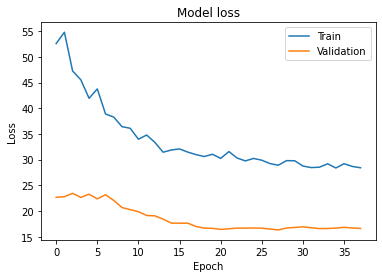

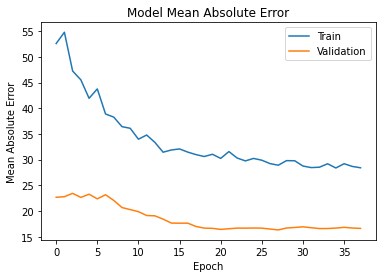

In [715]:
def plot_loss_mae(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
plot_loss_mae(history)

In [716]:
X_test_sj = scaler_sj.transform(X_test_sj)

In [717]:
y_pred_sj = model.predict(X_test_sj)

In [718]:
y_pred_sj.astype(int)

array([[ 7],
       [ 7],
       [ 6],
       [ 6],
       [ 6],
       [ 5],
       [ 5],
       [ 7],
       [ 8],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [15],
       [19],
       [18],
       [19],
       [22],
       [25],
       [21],
       [24],
       [21],
       [17],
       [18],
       [13],
       [15],
       [17],
       [14],
       [13],
       [12],
       [11],
       [ 9],
       [ 8],
       [ 8],
       [10],
       [12],
       [ 9],
       [ 5],
       [ 6],
       [ 6],
       [ 6],
       [ 7],
       [ 6],
       [ 5],
       [ 7],
       [ 7],
       [ 8],
       [ 8],
       [ 7],
       [ 7],
       [ 7],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 8],
       [ 8],
       [ 9],
       [ 9],
       [ 8],
       [11],
       [11],
       [10],
       [12],
       [15],
       [14],
       [15],
       [18],
       [17],
       [18],
       [18],
       [19],
       [17],
       [20],
       [22],
       [22],

#### Iquitos

In [719]:
X_train_iq = deng_iq_train.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_train_iq = deng_iq_train['total_cases']
X_val_iq = deng_iq_val.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_val_iq = deng_iq_val['total_cases']
X_test_iq = test_iq.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear'])

In [720]:
scaler_iq = RobustScaler()
X_train_iq = scaler_iq.fit_transform(X_train_iq)
X_val_iq = scaler_iq.transform(X_val_iq)

In [721]:
# LAYERS
def init_model():

    model = models.Sequential()
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dropout(rate=0.4))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dropout(rate=0.4))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(rate=0.4))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dropout(rate=0.4))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mean_absolute_error', 
                  optimizer='adam', 
                  metrics=['mae'])
    return model

model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

history_iq = model.fit(X_train_iq, y_train_iq,
            validation_split=0.10,
            epochs=1000, 
            batch_size=16,
            callbacks=[es])
model.evaluate(X_val_iq, y_val_iq)

Epoch 1/1000
26/26 [==============================] - 1s 12ms/step - loss: 7.3642 - mae: 7.3642 - val_loss: 14.3112 - val_mae: 14.3112
Epoch 2/1000
26/26 [==============================] - 0s 3ms/step - loss: 7.5379 - mae: 7.5379 - val_loss: 14.2343 - val_mae: 14.2343
Epoch 3/1000
26/26 [==============================] - 0s 4ms/step - loss: 6.6535 - mae: 6.6535 - val_loss: 14.1410 - val_mae: 14.1410
Epoch 4/1000
26/26 [==============================] - 0s 4ms/step - loss: 6.5961 - mae: 6.5961 - val_loss: 14.0217 - val_mae: 14.0217
Epoch 5/1000
26/26 [==============================] - 0s 3ms/step - loss: 6.8596 - mae: 6.8596 - val_loss: 13.8449 - val_mae: 13.8449
Epoch 6/1000
26/26 [==============================] - 0s 3ms/step - loss: 5.8678 - mae: 5.8678 - val_loss: 13.6794 - val_mae: 13.6794
Epoch 7/1000
26/26 [==============================] - 0s 3ms/step - loss: 5.6717 - mae: 5.6717 - val_loss: 13.5171 - val_mae: 13.5171
Epoch 8/1000
26/26 [==============================] - 0s 3ms/

Epoch 62/1000
26/26 [==============================] - 0s 3ms/step - loss: 5.1828 - mae: 5.1828 - val_loss: 11.8569 - val_mae: 11.8569
Epoch 63/1000
26/26 [==============================] - 0s 5ms/step - loss: 5.1499 - mae: 5.1499 - val_loss: 11.8775 - val_mae: 11.8775
Epoch 64/1000
26/26 [==============================] - 0s 4ms/step - loss: 4.9581 - mae: 4.9581 - val_loss: 11.8218 - val_mae: 11.8218
Epoch 65/1000
26/26 [==============================] - 0s 3ms/step - loss: 4.9381 - mae: 4.9381 - val_loss: 11.7902 - val_mae: 11.7902
Epoch 66/1000
26/26 [==============================] - 0s 3ms/step - loss: 5.1675 - mae: 5.1675 - val_loss: 11.7810 - val_mae: 11.7810
Epoch 67/1000
26/26 [==============================] - 0s 3ms/step - loss: 5.5932 - mae: 5.5932 - val_loss: 11.7540 - val_mae: 11.7540
Epoch 68/1000
26/26 [==============================] - 0s 3ms/step - loss: 5.1234 - mae: 5.1234 - val_loss: 11.8157 - val_mae: 11.8157
Epoch 69/1000
26/26 [==============================] - 

[3.5682621002197266, 3.5682621002197266]

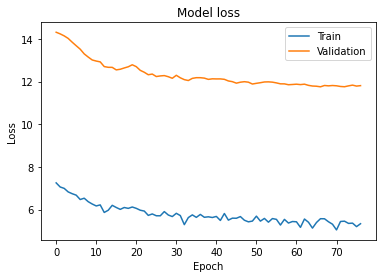

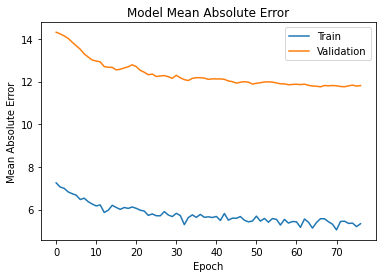

In [722]:
plot_loss_mae(history_iq)

In [723]:
X_test_iq = scaler_iq.transform(X_test_iq)
y_pred_iq = model.predict(X_test_iq)

In [724]:
y_pred_iq.astype(int)

array([[4],
       [3],
       [3],
       [2],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [3],
       [2],
       [1],
       [3],
       [2],
       [3],
       [5],
       [3],
       [1],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [3],
       [3],
       [3],
       [2],
       [3],
       [2],
       [4],
       [5],
       [2],
       [2],
       [3],
       [3],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [4],
       [2],
       [2],
       [1],
       [1],
       [1],
       [2],
       [1],
       [5],
       [2],
       [5],
       [2],
       [2],
       [2],
       [3],
    

### Submission

In [734]:
def submission(predictions_sj, predictions_iq, test_sj, test_iq):
    
    prediction_sj = []
    for p in y_pred_sj:
        prediction_sj.append(int(p))

    prediction_iq = []
    for p in y_pred_iq:
        prediction_iq.append(int(p))
    
    submission_sj = test_sj[['city', 'year', 'weekofyear']]
    submission_sj['total_cases'] = prediction_sj
    submission_iq = test_iq[['city', 'year', 'weekofyear']]
    submission_iq['total_cases'] = prediction_iq
    
    submission_final = pd.concat([submission_sj, submission_iq], axis=0)
    
    return submission_final

In [735]:
submission_nn = submission(y_pred_sj, y_pred_iq, test_sj, test_iq)
submission_nn.to_csv('data/submission_nn.csv', index=False)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
